# ChurnInsight – Modelo de Churn com XGBoost (Telco)

Notebook para o desafio **ChurnInsight** com foco em:
- Análise exploratória de dados (EDA);
- Preparação e engenharia simples de atributos;
- Treinamento de um modelo de **classificação binária** utilizando **XGBoost**;
- Avaliação com métricas clássicas de classificação;
- Serialização do pipeline completo para uso em produção (API).

Dataset utilizado: `WA_Fn-UseC_-Telco-Customer-Churn.csv` (problema de churn em serviços de telecom).


### 1. Imports e configuração do ambiente


In [41]:
# Se necessário, instale as dependências (execute apenas uma vez no terminal ou numa célula)
# !pip install pandas numpy scikit-learn xgboost joblib matplotlib

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)


## Carregamento dos dados

Carregamos o dataset Telco Customer Churn a partir da pasta `data/raw`.


In [42]:
caminho_csv = "../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv"  
df = pd.read_csv(caminho_csv)

print("Formato do dataset:", df.shape)
df.head()


Formato do dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. EDA – Análise Exploratória de Dados

Nesta seção vamos:
- Inspecionar tipos de dados;
- Verificar valores ausentes;
- Observar a distribuição da variável alvo (`Churn`).


In [43]:
print("=== Info do DataFrame ===")
print(df.info())


=== Info do DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling

In [44]:
print("=== Estatísticas descritivas (apenas numéricas) ===")
df.describe()


=== Estatísticas descritivas (apenas numéricas) ===


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [45]:
print("=== Distribuição de Churn (absoluta) ===")
print(df["Churn"].value_counts())

print("\n=== Distribuição de Churn (proporcional) ===")
print(df["Churn"].value_counts(normalize=True))


=== Distribuição de Churn (absoluta) ===
Churn
No     5174
Yes    1869
Name: count, dtype: int64

=== Distribuição de Churn (proporcional) ===
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


## Limpeza, X e y

In [46]:
# Converter TotalCharges para numérico (há valores em branco representados como espaço)
df["TotalCharges"] = pd.to_numeric(
    df["TotalCharges"].replace(" ", np.nan),
    errors="coerce"
)

# Preencher valores ausentes em TotalCharges com a mediana
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Remover qualquer linha eventualmente sem target
df = df.dropna(subset=["Churn"])

# Target binário: 0 = No (não cancela), 1 = Yes (cancela)
y = df["Churn"].map({"No": 0, "Yes": 1})

# Features: removemos customerID e Churn
X = df.drop(columns=["customerID", "Churn"])

X.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


## 5. Engenharia de atributos e pré-processamento

Vamos separar colunas numéricas e categóricas e criar um `ColumnTransformer` com:
- `passthrough` para numéricas;
- `OneHotEncoder` para categóricas.


#### 5.1 Listas de colunas

In [47]:
# Colunas numéricas
numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]

# Colunas categóricas = todas as demais
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Colunas numéricas:", numeric_features)
print("Colunas categóricas:", categorical_features)


Colunas numéricas: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Colunas categóricas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


#### 5.2 ColumnTransformer

In [48]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        (
            "cat",
            OneHotEncoder(drop="first", handle_unknown="ignore"),
            categorical_features,
        ),
    ]
)

preprocess


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,'first'
,sparse_output,True


### 6 Modelo + Pipeline

In [49]:
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", xgb_model),
    ]
)

clf


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 7. Separação treino/teste e treinamento do modelo


In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("Tamanho treino:", X_train.shape)
print("Tamanho teste:", X_test.shape)


Tamanho treino: (5634, 19)
Tamanho teste: (1409, 19)


In [51]:
# Treinamento do pipeline completo
clf.fit(X_train, y_train)

print("Treinamento concluído.")


Treinamento concluído.


## 8. Avaliação do modelo

Vamos calcular:
- Acurácia;
- Precisão;
- Recall;
- F1-score;
- ROC AUC;
- Relatório de classificação e matriz de confusão.


=== Métricas no conjunto de teste ===
Acurácia : 0.7991
Precisão : 0.6502
Recall   : 0.5267
F1-score : 0.5820
ROC AUC  : 0.8404

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

=== Matriz de Confusão ===
[[929 106]
 [177 197]]


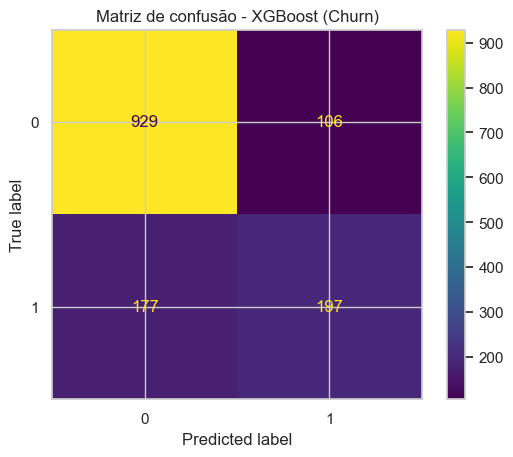

In [52]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("=== Métricas no conjunto de teste ===")
print(f"Acurácia : {accuracy:.4f}")
print(f"Precisão : {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("=== Matriz de Confusão ===")
print(confusion_matrix(y_test, y_pred))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de confusão - XGBoost (Churn)")
plt.show()


## 9. Serialização do pipeline

Aqui salvamos o pipeline completo (`pré-processamento + modelo XGBoost`) em disco,
para posterior uso em API ou microserviço de previsão.


In [ ]:
nome_arquivo_modelo = "../model/churn_xgboost_pipeline.joblib"
joblib.dump(clf, nome_arquivo_modelo)
print(f"Pipeline salvo em: {nome_arquivo_modelo}")


Pipeline salvo em: churn_xgboost_pipeline.joblib


## 10. Função auxiliar de previsão para uso em produção / API

A função abaixo:
- Carrega o modelo treinado;
- Recebe um dicionário com os dados do cliente;
- Retorna um dicionário no formato do contrato esperado pela API:
  - `previsao`: "Vai cancelar" ou "Vai continuar";
  - `probabilidade`: valor entre 0 e 1.


In [54]:
def carregar_modelo(caminho_modelo: str = "churn_xgboost_pipeline.joblib"):
    """Carrega o pipeline de churn treinado (pré-processamento + XGBoost)."""
    return joblib.load(caminho_modelo)


def prever_cliente(dados_cliente: dict, modelo=None):
    """
    Recebe um dicionário com os dados do cliente e retorna previsão e probabilidade.

    Exemplo de entrada (campos compatíveis com o dataset original, sem customerID e sem Churn):

    dados_cliente = {
        "gender": "Female",
        "SeniorCitizen": 0,
        "Partner": "Yes",
        "Dependents": "No",
        "tenure": 12,
        "PhoneService": "Yes",
        "MultipleLines": "No",
        "InternetService": "Fiber optic",
        "OnlineSecurity": "No",
        "OnlineBackup": "Yes",
        "DeviceProtection": "No",
        "TechSupport": "No",
        "StreamingTV": "Yes",
        "StreamingMovies": "No",
        "Contract": "Month-to-month",
        "PaperlessBilling": "Yes",
        "PaymentMethod": "Electronic check",
        "MonthlyCharges": 70.35,
        "TotalCharges": 151.65,
    }
    """
    if modelo is None:
        modelo = carregar_modelo()

    X_novo = pd.DataFrame([dados_cliente])
    prob = modelo.predict_proba(X_novo)[:, 1][0]
    pred = int(prob >= 0.5)

    previsao_texto = "Vai cancelar" if pred == 1 else "Vai continuar"

    return {
        "previsao": previsao_texto,
        "probabilidade": float(prob),
    }


## 11. Exemplo de uso da função `prever_cliente`

Este exemplo simula a chamada que seria feita pelo back-end via API.


In [55]:
# Exemplo (ajuste os valores conforme necessário)
exemplo_cliente = {
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "No",
    "tenure": 12,
    "PhoneService": "Yes",
    "MultipleLines": "No",
    "InternetService": "Fiber optic",
    "OnlineSecurity": "No",
    "OnlineBackup": "Yes",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "Yes",
    "StreamingMovies": "No",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 70.35,
    "TotalCharges": 151.65,
}

modelo_carregado = carregar_modelo()
saida = prever_cliente(exemplo_cliente, modelo_carregado)
saida


{'previsao': 'Vai continuar', 'probabilidade': 0.476134717464447}